<a href="https://colab.research.google.com/github/Aenirudh/deep_learning_class/blob/main/tl_mpl_cf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Experiments Used to Select NN Parameters

Optimized Parameters:
1) Number of hidden neurons: 5
2) Learning rate
3) Momentum constant
4) Initialize weights differently (initial guess)?
5) Activation function a,b
6) Epoch
7) Training examples

Experiment 1: Optimize 1) by setting # neurons to mean (5) of input (9) and output (1)
Parameters:
1) 5
2) torch.linspace(0.1, 1e-5, 50)
3) alpha = 1
6) Epoch = 50
7) 1392, 2785
Observation: Linear decrease, slow
Final MSE: 0.57 | Testing Error: 79.96 %

Experiment 2: Optimize 1) by setting # neurons to mean - 1 (4)
Parameters:
1) 4
2) torch.linspace(0.1, 1e-5, 50)
3) alpha = 1
6) Epoch = 50
7) 1392, 2785
Observation: Noisy (osscilitaroty behaviour), linear decrease, slow
Final MSE: 0.57 | Testing Error: 78.82 %

Experiment 3: Optimize 1) by setting # neurons to mean + 1 (6)
Parameters:
1) 6
2) torch.linspace(0.1, 1e-5, 50)
3) alpha = 1
6) Epoch = 50
7) 1392, 2785
Observation:
Final MSE: 0.61 | Testing Error: 75.73 %

Experiment 4: Optimize 1) by setting learning rate start to 0.01
Parameters:
1) 5
2) eta = torch.linspace(0.01, 1e-5, total_epoch)
3) alpha = 1
6) Epoch = 50
7) 1392, 2785
Observation:
Final MSE: 0.58 | Testing Error: 80.07 %

Experiment 5: Optimize 7) by setting learning examples to 3133 and learning examples to 1044
Parameters:
1) 5
2) eta = torch.linspace(0.01, 1e-5, total_epoch)
3) alpha = 1
6) Epoch = 50
7) 3133, 1044
Observation:
Final MSE: 0.55 | Testing Error: 80.46 %

Experiment 6: Optimize 2) by setting learning rate start to 0.005
Parameters:
1) 5
2) eta = torch.linspace(0.005, 1e-5, total_epoch)
3) alpha = 1
6) Epoch = 50
7) 3133, 1044
Observation:
Final MSE: 0.55 | Testing Error: 80.17 %

Experiment 5: Optimize 7) by setting total Epochs to 500
Parameters:
1) 5
2) eta = torch.linspace(0.01, 1e-5, total_epoch)
3) alpha = 1
6) Epoch = 500
7) 3133, 1044
Observation:
Final MSE: converged 0.58 mse

"""

In [ ]:
""" Import libraries """
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import torch

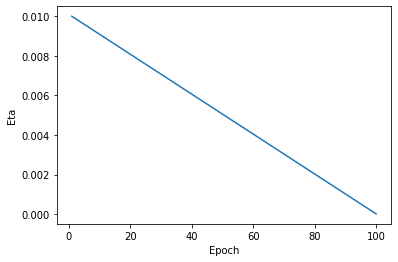

In [ ]:
""" NN Variables and Parameters """
number_root_boundary = 9 # number of roots to split the data into two classes
total_epoch = 100
activation_func_a = 1.0
activation_func_b = 1.0
eta = torch.linspace(0.01, 1e-5, total_epoch)
#eta = (torch.cos(torch.linspace(0, np.pi*3, total_epoch)) + 1)*0.005
alpha = 1
train_ex = 3133
test_ex = 1044
mse_thresh = 1e-3
mse_train = float("Inf")
n_in = 8 # number of input neurons
n_hd = 5 # number of hidden neurons
n_out = 1 # number of output neurons 
n_hdl = 3 # number of hidden layers

wi1 = torch.rand(n_hd,n_in+1, dtype=torch.float64) # weights between input layer and hidden layer 1
w12 = torch.rand(n_hd,n_hd+1, dtype=torch.float64) # weights between hidden layer 1 and hidden layer 2
w23 = torch.rand(n_hd,n_hd+1, dtype=torch.float64) # weights between hidden layer 2 and hidden layer 3
w3o = torch.rand(1,n_hd+1, dtype=torch.float64) # weights between hidden layer 3 and output layer

dw_prev_i1 = torch.zeros(n_hd,n_in+1, dtype=torch.float64) # previous difference in weights between input layer and hidden layer 1
dw_prev_12 = torch.zeros(n_hd,n_hd+1, dtype=torch.float64) # " " hidden layer 1 and hidden layer 2
dw_prev_23 = torch.zeros(n_hd,n_hd+1, dtype=torch.float64) # " " hidden layer 2 and hidden layer 3
dw_prev_3o = torch.zeros(1,n_hd+1, dtype=torch.float64) # " " hidden layer 3 and output layer

mse = torch.zeros(total_epoch)

""" Input Variables and Parameters """
data_file = '/content/drive/MyDrive/3l_mpl_backprojection/abalone_edited.data'

""" Plot Learning Curve """
x_axis = np.arange(1, total_epoch+1, 1)
plt.plot(x_axis, eta)
plt.xlabel('Epoch')
plt.ylabel('Eta')
plt.show()

In [ ]:
""" Pre-Processing Input """
# get all the data from the input file
data = genfromtxt(data_file, delimiter=',')

# remove mean and normalize data increasing speed during training
mean = data.mean(axis=0)
max = np.zeros(n_in+1)

for i in range(data.shape[0]):
  data[i, 0:n_in] = data[i, 0:n_in] - mean[0:n_in]

for i in range(9):
  max[i] = np.max(np.absolute(data[:,i]))

for i in range(data.shape[0]):
  data[i, 0:n_in] = data[i, 0:n_in]/max[0:n_in]

""" Labeling outputs (# Rings <= 9 -> +1 and # Rings > 9 -> -1) """
for i in range(data.shape[0]):
  if data[i, n_in] <= number_root_boundary: data[i, n_in] = -1.0
  elif data[i, n_in] > number_root_boundary: data[i, n_in] = 1.0

""" Convert numpy data to torch tensor """
data_t = torch.from_numpy(data)

""" Shuffle Data """
if True:
  shuffle_idx = torch.randperm(train_ex+test_ex)
  data_t = data_t[shuffle_idx]

In [ ]:
""" Training Section """
train_data_t = data_t[0:train_ex]
err = torch.zeros(train_ex) # tensor to store error for each example
i_epoch = 0

while mse_train >= mse_thresh and i_epoch < total_epoch:
  # Shuffle input data every epoch
  shuffle_idx = torch.randperm(train_ex)
  train_data_t = train_data_t[shuffle_idx]

  for i in range(train_ex):
    """ Forward Pass """
    # input and desired data
    i_t = train_data_t[i, 0:n_in]
    i_t = torch.cat((i_t, torch.tensor([1]))) # bias input 1
    d_t = train_data_t[i, n_in]

    # hidden layer 1 computations
    hd1 = torch.tanh(torch.matmul(wi1,i_t))

    # hidden layer 2 computations
    hd1 = torch.cat((hd1, torch.tensor([1])))
    hd2 = torch.tanh(torch.matmul(w12,hd1))

    # hidden layer 3 computations
    hd2 = torch.cat((hd2, torch.tensor([1])))
    hd3 = torch.tanh(torch.matmul(w23,hd2))

    # output layer computations
    hd3 = torch.cat((hd3, torch.tensor([1])))
    o = torch.tanh(torch.matmul(w3o,hd3))

    # error calculation
    err[i] = d_t - o[0]

    """ Backward Pass """
    # Calculate local gradients for the output layer and each hidden layer
    lgrad_o = err[i] * (1 - (torch.tanh(torch.matmul(w3o,hd3)) ** 2)) # torch.square
    lgrad_3 = (1 - (torch.tanh(torch.matmul(w23,hd2)) ** 2)) * (w3o[0,0:-1] * lgrad_o) # torch.square
    lgrad_2 = (1 - (torch.tanh(torch.matmul(w12,hd1)) ** 2)) * torch.sum(w23[:,0:-1]*lgrad_3, dim=1) # torch.square
    lgrad_1 = (1 - (torch.tanh(torch.matmul(wi1,i_t)) ** 2)) * torch.sum(w12[:,0:-1]*lgrad_2, dim=1) # torch.square

    # Calculate the difference in weights between each layer
    dw_3o = eta[i_epoch] * lgrad_o * hd3
    dw_23 = eta[i_epoch] * torch.ger(lgrad_3,hd2)
    dw_12 = eta[i_epoch] * torch.ger(lgrad_2,hd1)
    dw_i1 = eta[i_epoch] * torch.ger(lgrad_1,i_t)

    # Calculate updated weights, SGDM Optimizer Selected
    wi1 = wi1 + (alpha * dw_prev_i1) + dw_i1
    w12 = w12 + (alpha * dw_prev_12) + dw_12
    w23 = w23 + (alpha * dw_prev_23) + dw_23
    w3o = w3o + (alpha * dw_prev_3o) + dw_3o

    # Update the previous difference in weights
    dw_prev_i1 = dw_i1
    dw_prev_12 = dw_12
    dw_prev_23 = dw_23
    dw_prev_3o = dw_3o

  """ Update mse, mse_train, epoch """
  mse_train = torch.mean(torch.square(err))
  mse[i_epoch] = mse_train
  i_epoch = i_epoch + 1
  print(f'Epoch {i_epoch} finished, mse is {mse_train}')

Epoch 1 finished, mse is 0.8239877820014954
Epoch 2 finished, mse is 0.7157161235809326
Epoch 3 finished, mse is 0.6899425983428955
Epoch 4 finished, mse is 0.678707480430603
Epoch 5 finished, mse is 0.6611412167549133
Epoch 6 finished, mse is 0.6378356218338013
Epoch 7 finished, mse is 0.6347522735595703
Epoch 8 finished, mse is 0.6262840032577515
Epoch 9 finished, mse is 0.6216818690299988
Epoch 10 finished, mse is 0.6112056970596313
Epoch 11 finished, mse is 0.6139258742332458
Epoch 12 finished, mse is 0.6167649626731873
Epoch 13 finished, mse is 0.6086955666542053
Epoch 14 finished, mse is 0.605376124382019
Epoch 15 finished, mse is 0.6058389544487
Epoch 16 finished, mse is 0.5967926979064941
Epoch 17 finished, mse is 0.6023609042167664
Epoch 18 finished, mse is 0.5956459045410156
Epoch 19 finished, mse is 0.5955132842063904
Epoch 20 finished, mse is 0.5893754959106445
Epoch 21 finished, mse is 0.5883110165596008
Epoch 22 finished, mse is 0.589192271232605
Epoch 23 finished, mse is

Points trained 3133
Epochs conducted 100
Final MSE was 0.531908392906189


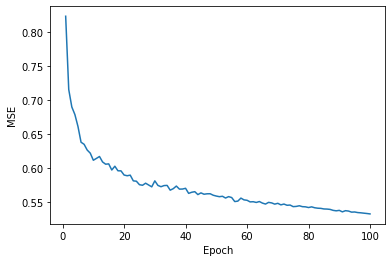

In [ ]:
""" Learning Statistics """
print(f'Points trained {train_ex}')
print(f'Epochs conducted {total_epoch}')
print(f'Final MSE was {mse[total_epoch-1]}')
x_axis = np.arange(1, total_epoch+1, 1)
plt.plot(x_axis, mse)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

In [ ]:
""" Test Section """
test_data_t = data_t[train_ex:]
test_err = 0

""" Forward Pass """
for i in range(test_ex):
  # input and desired data
  i_t = test_data_t[i, 0:n_in]
  i_t = torch.cat((i_t, torch.tensor([1]))) # bias input 1
  d_t = test_data_t[i, n_in]

  # hidden layer 1 computations
  hd1 = torch.tanh(torch.matmul(wi1,i_t))

  # hidden layer 2 computations
  hd1 = torch.cat((hd1, torch.tensor([1])))
  hd2 = torch.tanh(torch.matmul(w12,hd1))

  # hidden layer 3 computations
  hd2 = torch.cat((hd2, torch.tensor([1])))
  hd3 = torch.tanh(torch.matmul(w23,hd2))

  # output layer computations
  hd3 = torch.cat((hd3, torch.tensor([1])))
  o = torch.tanh(torch.matmul(w3o,hd3))

  # error calculation
  print(f'o: {o} | torch.sign(o): {torch.sign(o)[0]} | d_t: {d_t} | torch.sign(o)[0] - d_t: {torch.sign(o)[0] - d_t} | abs: {torch.abs(torch.sign(o)[0] - d_t)}')
  if torch.abs(torch.sign(o)[0] - d_t) > 1e-6:
    test_err = test_err + 1

""" Testing Statistics """
print(f'Points tested: {test_ex}')
print(f'Points identified incorrectly: {test_err}')
print(f'Accuracy: {round(((test_ex-test_err)/test_ex)*100,2)} %')

o: tensor([0.1875], dtype=torch.float64) | torch.sign(o): 1.0 | d_t: 1.0 | torch.sign(o)[0] - d_t: 0.0 | abs: 0.0
o: tensor([0.5873], dtype=torch.float64) | torch.sign(o): 1.0 | d_t: 1.0 | torch.sign(o)[0] - d_t: 0.0 | abs: 0.0
o: tensor([0.2011], dtype=torch.float64) | torch.sign(o): 1.0 | d_t: 1.0 | torch.sign(o)[0] - d_t: 0.0 | abs: 0.0
o: tensor([0.8270], dtype=torch.float64) | torch.sign(o): 1.0 | d_t: 1.0 | torch.sign(o)[0] - d_t: 0.0 | abs: 0.0
o: tensor([0.8132], dtype=torch.float64) | torch.sign(o): 1.0 | d_t: 1.0 | torch.sign(o)[0] - d_t: 0.0 | abs: 0.0
o: tensor([0.6716], dtype=torch.float64) | torch.sign(o): 1.0 | d_t: 1.0 | torch.sign(o)[0] - d_t: 0.0 | abs: 0.0
o: tensor([0.5303], dtype=torch.float64) | torch.sign(o): 1.0 | d_t: 1.0 | torch.sign(o)[0] - d_t: 0.0 | abs: 0.0
o: tensor([0.7645], dtype=torch.float64) | torch.sign(o): 1.0 | d_t: -1.0 | torch.sign(o)[0] - d_t: 2.0 | abs: 2.0
o: tensor([0.1656], dtype=torch.float64) | torch.sign(o): 1.0 | d_t: 1.0 | torch.sign(o